In [ ]:
!pip install geoio

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 23.7MB 1.5MB/s 
  Created wheel for tzwhere: filename=tzwhere-3.0.3-cp37-none-any.whl size=23742584 sha256=f8bafcdfb0870c5bf850e2c84aa5c11c2d8da87ba3b194c2b5d783d59f53c870
  Stored in directory: /root/.cache/pip/wheels/89/18/2f/01c958c82b1223d6fe763c6b2fadf45b4f6ce6e8a9fce7bbd5
Successfully built tzwhere


In [ ]:
#Use the "Space" environemnt 
from pathlib import Path
from osgeo import gdal, osr
import numpy as np
import json
import sys
import geoio  
import cv2 
import os 

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

In [ ]:
#mount my personal colabgoogle drive to this notebook. To use local files, you have to run colab from your local runtime
from google.colab import drive
drive.mount('/content/drive')

#create path object that is in your google drive 
path = Path('/content/drive/MyDrive/DSC 449 Project') #
Path.BASE_PATH = path

#folder system: 
#DSC 449 Project
#-Test
#--GeoJson
#--images
#-Train
#--GeoJson
#--images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# For a Sample Image: 

In [ ]:
#Define file locations on desktop computer 
root = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/"

geojson_path = "geojson/buildings/"                      #1012 geojson files in this directory
sample_geojson ="buildings_AOI_5_Khartoum_img1.geojson" 

img_path = "MUL-PanSharpen/"                             #1012 imgs in this directory
sample_img = "MUL-PanSharpen_AOI_5_Khartoum_img1.tif"

geojson_file = root + geojson_path + sample_geojson
img_file = root + img_path + sample_img

### Manually: 

In [ ]:
#Open geogjson label file 
with open(geojson_file) as f:
    shapes = json.load(f)

#Verify that we have 26 buildings in this image
len(shapes['features'])

26

In [ ]:
#pull one of those buildings as our sample
n = 1 #object number 
sample_building = shapes['features'][n]['geometry']['coordinates'][0] #the last 0 steps into the list object  
sample_building = np.array(sample_building)[:,:2] #only keep x and y (drop z coordinate)
sample_building #the last point should be the same as the first (to close the polygon)

array([[32.48711206, 15.51459853],
       [32.48711206, 15.51454997],
       [32.48717005, 15.51454997],
       [32.48717005, 15.51451425],
       [32.48717005, 15.51447944],
       [32.48709304, 15.51447943],
       [32.48709304, 15.51451425],
       [32.48700938, 15.51451425],
       [32.48700938, 15.51459853],
       [32.48711206, 15.51459853]])

In [ ]:
#open reference image and get size, sample band, and GeoTransform 
dataset = gdal.Open(img_file) #open to raster as "dataset" 
band = dataset.GetRasterBand(1) #get a random band from that raster 

#get the pixel dimensions of the image 
cols = dataset.RasterXSize
rows = dataset.RasterYSize

#get the affine matrix of the image 
transform = dataset.GetGeoTransform() #this is the Affine transform matrix 
xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

#use those transform values to get pixel coordinates 
data = band.ReadAsArray()

for lon,lat in sample_building:
    col = round((lon - xOrigin) / pixelWidth)
    row = round((yOrigin - lat) / pixelHeight)

    print(row, col, data[row][col]) #data[][] is the pixel value at those coordinates 
    

358 472 383
376 472 411
376 493 404
390 493 399
403 493 369
403 465 398
390 465 403
390 434 382
358 434 389
358 472 383


### Alternatively: 

In [ ]:
#open image using geoio instead of gdal 
img = geoio.GeoImage(img_file)

for lon,lat in sample_building:
    pix_y, pix_x = img.proj_to_raster(lon,lat) #use geoio method for transformation 
    print(round(pix_x), round(pix_y), data[round(pix_x)][round(pix_y)])

358 472 383
376 472 411
376 493 404
390 493 399
403 493 369
403 465 398
390 465 403
390 434 382
358 434 389
358 472 383


### Transform all buildings in an image: 

In [ ]:
img_file = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_5_Khartoum_img10.tif"
geojson_file = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/geojson/buildings/buildings_AOI_5_Khartoum_img10.geojson"

#open image 
img = geoio.GeoImage(img_file)

#open geojson labels 
with open(geojson_file) as f:
    geojson_data = json.load(f)

#for each object, get it's lon,lat coordinates 
latlons = [] 
feature_types = [] 
for feature in geojson_data['features']:
    obj_coords = feature['geometry']['coordinates'][0] #get the list of coordinats for this object 
    obj_type = feature['geometry']['type'] #in case you want to filter on feature type 

    latlons.append(obj_coords) #latlons is a list of np arrays. Each np array is a list of x,y coordinates. 
    feature_types.append(obj_type) 

# convert latlons to pixel coords for all points in all objects of this image 
pixel_coords = []
latlon_coords = []
for poly in latlons:

    # account for double-wrapped arrays 
    poly = remove_double_wrap(poly)
    poly=np.array(poly)
    
    print(len(poly.shape), type(poly))

2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'numpy.ndarray'>
2 <class 'nu

In [ ]:
for i, poly in enumerate(latlons):
    for ind, point in enumerate(poly):
        if len(point)>3:
            print(i,ind)

68 0


In [ ]:
latlons[68][0][0]

[32.489988996581374, 15.515566199936622, 0.0]

In [ ]:
#remove double wrap works! 
remove_double_wrap(latlons[68])

[[32.489988996581374, 15.515566199936622, 0.0],
 [32.48998906100008, 15.51556368600005, 0.0],
 [32.48990921600011, 15.515561787000019, 0.0],
 [32.48990910291692, 15.515566199936622, 0.0],
 [32.489988996581374, 15.515566199936622, 0.0]]

In [ ]:
def remove_double_wrap(input_list):
    #recursive check to remove double wrapped lists 
    try:
        if isinstance(input_list[0][0], list):
            return remove_double_wrap(input_list[0]) #remove one wrapping with index [0] 
        else:#if going two steps down returns something that's not a list, then it's not double wrapped 
            return input_list
    except: #if that failed, then our list is not double wrapped
        return input_list

In [ ]:
def LonLat2Pixels(img_path, geojson_path):
    import geoio
    import numpy as np 
    
    #open image 
    img = geoio.GeoImage(img_path)

    #open geojson labels 
    with open(geojson_path) as f:
        geojson_data = json.load(f)
    
    #for each object, get it's lon,lat coordinates 
    latlons = [] 
    feature_types = [] 
    for feature in geojson_data['features']:
        obj_coords = feature['geometry']['coordinates'][0] #get the list of coordinats for this object 
        obj_type = feature['geometry']['type'] #in case you want to filter on feature type 
        
        latlons.append(obj_coords) #latlons is a list of np arrays. Each np array is a list of x,y coordinates. 
        feature_types.append(obj_type) 
    
    # convert latlons to pixel coords for all points in all objects of this image 
    pixel_coords = []
    latlon_coords = []
    for poly in latlons:
        
        # account for double-wrapped arrays 
        poly = remove_double_wrap(poly)
        poly=np.array(poly)
        
        #if this is an empty array or has 0 or 1 dimensions, go to next polygon 
        if len(poly.shape) < 2:
            continue 
        if not np.any(poly):
            continue
        
        #get pixel coordinates for each point in this polygon 
        poly_list_pix = []
        poly_list_latlon = []
        for lon,lat,z in poly:
            px, py = img.proj_to_raster(lon, lat) #use the reference image's affine matrix to make the tranformation
            poly_list_pix.append([round(px), round(py)])
    
        #add polygon's pixel coordinates to output 
        pixel_coords.append(poly_list_pix)
        
    return pixel_coords

In [ ]:
pixel_coords = LonLat2Pixels(img_file, geojson_file)

#verify that we still have 26 buildings, now in pixel coordinates 
len(pixel_coords)

15

### Make mask from pixel coordinates for a single image 

In [ ]:
def create_building_mask(img_path, geojson_path):
    from osgeo import gdal 
    import numpy as np
    import cv2
    
    #size mask to reference image size 
    srcRas_ds = gdal.Open(img_path)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
    mask = np.zeros((cols, rows))

    #convert geojson to pixel coordinates 
    pixel_coords = LonLat2Pixels(img_path, geojson_path) 
    
    #for each building 
    for poly in pixel_coords: 
        pts = np.int32(poly) # Bug with fillPoly, needs explict cast to 32bit
        mask = cv2.fillPoly(mask, [pts], color=255)
    
    return mask

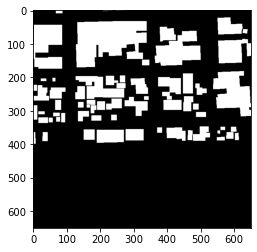

In [ ]:
img_file = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_5_Khartoum_img10.tif"
geojson_file = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/geojson/buildings/buildings_AOI_5_Khartoum_img10.geojson"
mask = create_building_mask(img_file, geojson_file)
plt.imshow(mask, cmap="gray")

In [ ]:
info = gdal.Info(img_file, options='-json')['geoTransform']
info[0], info[3]

(32.4858384, 15.5155661999)

### Display mask for a single image 

In [ ]:
def display_mask(input_image, pixel_coords,   
                  figsize=(8,8), 
                  plot_name='',
                  poly_face_color='green', 
                  poly_edge_color='white',#'red', 
                  poly_nofill_color='white', #'blue', 
                  cmap='gray'):
    '''Plot ground truth coordinaates, pixel_coords should be a numpy array'''
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*figsize[0], figsize[1]))
    
    # create patches
    patches = []
    patches_nofill = []
    if len(pixel_coords) > 0:
        # get patches    
        for coord in pixel_coords:
            patches_nofill.append(Polygon(coord, facecolor=poly_nofill_color, 
                                          edgecolor=poly_edge_color, lw=3))
            
            patches.append(Polygon(coord, edgecolor=poly_edge_color, fill=True, 
                                   facecolor=poly_face_color))
        p0 = PatchCollection(patches, alpha=0.25, match_original=True)
        #p1 = PatchCollection(patches, alpha=0.75, match_original=True)
        p2 = PatchCollection(patches_nofill, alpha=0.75, match_original=True)
                   
    # ax0: raw image
    ax0.imshow(input_image, cmap=cmap)
    if len(patches) > 0:
        ax0.add_collection(p0)
    ax0.set_title('Input Image + Ground Truth Buildings') 
    ax0.axis('off')
    
    # truth polygons
    zero_arr = np.zeros(input_image.shape[:2])
    # set background to white?
    #zero_arr[zero_arr == 0.0] = np.nan
    ax1.imshow(zero_arr, cmap=cmap)
    if len(patches) > 0:
        ax1.add_collection(p2)
    ax1.set_title('Ground Truth Building Polygons')
    ax1.axis('off')
    
    #plt.tight_layout()
    plt.show()
 
    #save output image 
    if len(plot_name) > 0:
        plt.savefig(plot_name)
    
    return patches, patches_nofill

In [ ]:
dataset = gdal.Open(img_file) #open to raster as "dataset" 
band = dataset.GetRasterBand(1) #get a random band from that raster 
band = band.ReadAsArray() #converts to numpy array 

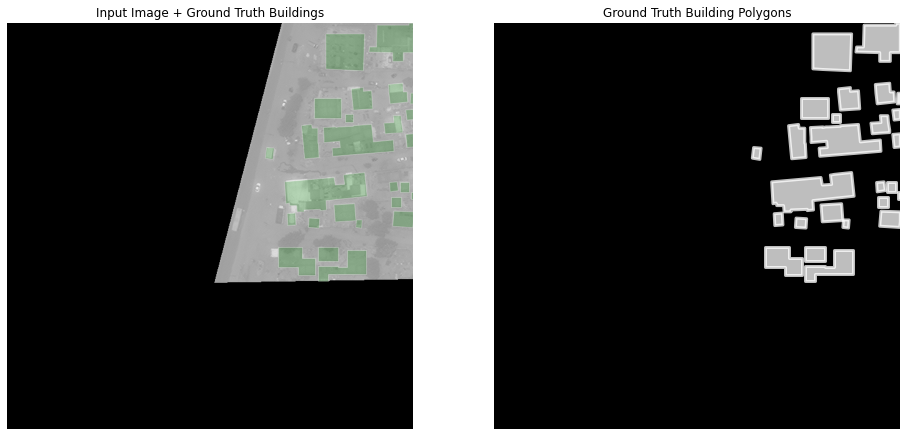

In [ ]:
%matplotlib inline
a, b = display_mask(band, pixel_coords)

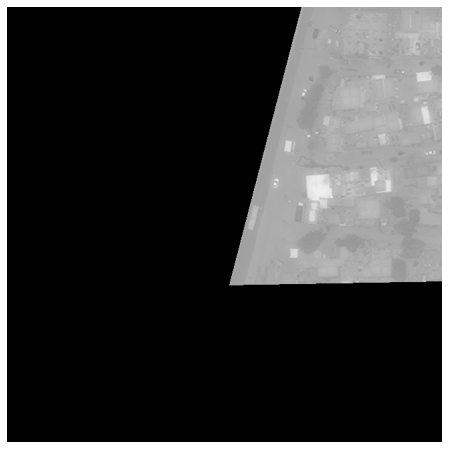

In [ ]:
#original image 
plt.figure(figsize= (8, 8))
plt.axis('off')
plt.imshow(band, cmap="gray")

# Create masks for each image in dataset 

In [ ]:
#Define file locations on desktop computer 
root = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/"

geojson_path = "geojson/buildings/"                      #1012 geojson files in this directory
sample_geojson ="buildings_AOI_5_Khartoum_img1.geojson" 

img_path = "MUL-PanSharpen/"                             #1012 imgs in this directory
sample_img = "MUL-PanSharpen_AOI_5_Khartoum_img1.tif"

In [ ]:
img_files = os.listdir(root+img_path)
geojson_files = os.listdir(root+geojson_path)

In [ ]:
#verify there are 1012 files in training dataset 
len(geojson_files), len(geojson_files)

(1012, 1012)

In [ ]:
def save_building_masks(root, img_ext, geojson_ext):
    from osgeo import gdal 
    import numpy as np
    import cv2
    import os 
    
    #get a list of items in each of the directories 
    img_dir = os.listdir(root+img_ext)
    geojson_dir = os.listdir(root+geojson_ext)
    
    if len(img_dir) != len(geojson_dir): 
        print(f'Directories don\'t have the same number of files. Check directories: \n{img_dir}\n{geojson_dir}')
        return 
    
    #make output directory in root 
    output_dir = root+"masks1/"
    try: 
        os.mkdir(output_dir)
    except:
        print("output directory already exists. Rename or delete directory to run this function.")
        return
    
    #For each image in the directory 
    for img_name, geojson_name in zip(img_dir, geojson_dir): 
        #define full file paths 
        img_filepath = root+img_ext+img_name
        json_filepath = root+geojson_ext+geojson_name
        
        #size mask to reference image 
        srcRas_ds = gdal.Open(img_filepath)
        cols = srcRas_ds.RasterXSize
        rows = srcRas_ds.RasterYSize
        mask = np.zeros((cols, rows))

        #convert geojson coordinates to pixel coordinates 
        pixel_coords = LonLat2Pixels(img_filepath, json_filepath) #function from above 

        #add each building to this image's mask, one building at a time  
        for poly in pixel_coords: 
            pts = np.int32(poly) # Bug with fillPoly, needs explict cast to 32bit
            mask = cv2.fillPoly(mask, [pts], color=255)
    
        #save the mask to output directory 
        output_name  = get_output_name(img_filepath) #output_file_name(geojson_name)
        cv2.imwrite(output_dir+output_name,mask)
    
    print("Done!")
    return 

In [ ]:
def get_output_name(img_file):
    info = gdal.Info(img_file, options='-json')['geoTransform']
    x, y = info[0], info[3]
    return f"buildings__{x}_{y}.png"

In [ ]:
#original function to get file name. remove the .geojson from annotation file name and add .png 
def output_file_name(geojson_name):
    return geojson_name.split('.')[0] + ".png" #change out .json for .png 

In [ ]:
#Define file locations on desktop computer 
roots = ["C:/Users/sbgass/Pictures/AOI_2_Vegas/AOI_2_Vegas_Train/",
         "C:/Users/sbgass/Pictures/AOI_3_Paris/AOI_3_Paris_Train/"]
geojson_path = "geojson/buildings/"
img_path = "MUL-PanSharpen/"

In [ ]:
import time 
for root in roots: 
    start = time.perf_counter() 
    save_building_masks(root, img_path, geojson_path)
    print(root.split("/")[-1]+":",time.perf_counter()-start, "seconds")

TypeError: iteration over a 0-d array

In [ ]:
#Save a single AOI 
root = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/"
geojson_path = "geojson/buildings/"
img_path = "MUL-PanSharpen/"
save_building_masks(root, img_path, geojson_path)

Done!


# Create Distance Map

In [ ]:
import json
from shapely.geometry import Polygon, shape, Point
from osgeo import gdal
import numpy as np
import sys
from numba import njit

In [ ]:
#Define file locations on desktop computer 
root = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/"

geojson_path = "geojson/buildings/"                      #1012 geojson files in this directory
sample_geojson ="buildings_AOI_5_Khartoum_img1580.geojson" 

img_path = "MUL-PanSharpen/"                             #1012 imgs in this directory
sample_img = "MUL-PanSharpen_AOI_5_Khartoum_img1580.tif"

geojson_file = root + geojson_path + sample_geojson
img_file = root + img_path + sample_img

In [ ]:
@njit
def Pixel2World ( aff, i , j ):
    #1 meter distance is negative 1 point penalty
    ulX = aff[0]
    ulY = aff[3]
    xDist = aff[1]
    yDist = aff[5]
    rtnX = aff[2]
    rtnY = aff[4]
    return (1.0 * i * xDist  + ulX, -1.0 * j * xDist + ulY)

Pixel2World( np.array([1,2,3,4,5,6]).reshape((2,3)), 12 , 13 )

(array([49., 62., 75.]),
 array([4.49668415e+18, 3.27368530e+18, 3.10935679e+16]))

In [ ]:
def save_adj_masks(root, img_ext, geojson_ext):
    from osgeo import gdal 
    from tqdm import tqdm
    import numpy as np
    import cv2
    import os 
    
    #get a list of items in each of the directories 
    img_dir = os.listdir(root+img_ext)
    geojson_dir = os.listdir(root+geojson_ext)
    
    if len(img_dir) != len(geojson_dir): 
        print(f'Directories don\'t have the same number of files. Check directories: \n{img_dir}\n{geojson_dir}')
        return 
    
    #make output directory in root 
    output_dir = root+"adj_masks/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for img_fn, json_fn in tqdm(zip(img_dir,geojson_dir)):
        create_dist_map(root+img_ext+img_fn, root+geojson_ext+json_fn, output_dir) #img, json paths 

In [ ]:
def create_dist_map(img_file,geojson_file, output_dir):

    ds8 = gdal.Open(img_file)
    geoTrans = ds8.GetGeoTransform() #Affine matrix
    
    with open(geojson_file,'r') as f:
        js = json.load(f)
        mask = np.zeros((ds8.RasterXSize, ds8.RasterYSize)) #create mask array 
        
        #loop over each pixel in mask 
        for i in range(ds8.RasterXSize):
            for j in range(ds8.RasterYSize):
                point = Point(Pixel2World(geoTrans,i,j)) #shapely function: Point(). with User defined function Pixel2World() 
                pd = float("-inf") #point distance
                #for every building in this image 
                for feature in js['features']:
                    polygon = shape(feature['geometry'])
                    newpd = point.distance(polygon.boundary) #shapely built-in function for distance to boundary! 
                    
                    #if this point is outside the polygon 
                    if False == polygon.contains(point): 
                        newpd = -1.0 * newpd #penalty for outside the building distance. 
                    if newpd > pd : #update point with it's closest distance
                        pd = newpd
                        
                mask[j,i] = pd #make point's distance it's intensity value 
                
    output_file = geojson_file.split("/")[-1][:-8]
    np.save(output_dir+output_file,mask)

In [ ]:
root = str(path)+"/Test/" #/content/drive/MyDrive/DSC 449 Project/
geojson_path = "GeoJson/"
img_path = "images/"

In [ ]:
img_file = root+img_path+"RGB-PanSharpen__32.4858384_15.5138111999.jpg"
geojson_file = root+geojson_path+"buildings__32.4858384_15.5138111999.geojson"

In [ ]:
#For a single mask 
import time 
start = time.perf_counter()
create_dist_map(img_file,geojson_file, root+"adj_masks/") 
print(time.perf_counter()-start,"seconds") #6.5 minutes per image! 1012 imgs = 110 hours 

475.404009203 seconds


In [ ]:
#For all masks:
save_adj_masks(root,img_path,geojson_path)

21it [10:20:33, 1773.01s/it]


KeyboardInterrupt: 

In [ ]:
#How to read a numpy .npy file 
test =np.load("C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/adj_masks/buildings_AOI_5_Khartoum_img100.npy")
np.min(test),np.max(test)

(-0.0005379958916937282, 7.830001514719241e-05)

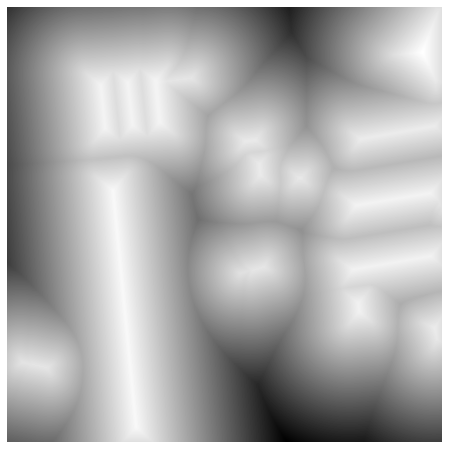

In [ ]:
#display numpy array   
plt.figure(figsize= (8, 8))
plt.axis('off')
plt.imshow(test, cmap="gray")

# Create Alternative distance maps 

In [ ]:
#use most of the same code as above 

In [ ]:
def create_alt_dist_map(img_file,geojson_file):

    ds8 = gdal.Open(img_file)
    geoTrans = ds8.GetGeoTransform() #Affine matrix
    
    with open(geojson_file,'r') as f:
        js = json.load(f)
        mask = np.zeros((ds8.RasterXSize, ds8.RasterYSize)) #create mask array 
        
        #loop over each pixel in mask 
        for i in range(ds8.RasterXSize):
            for j in range(ds8.RasterYSize):
                point = Point(Pixel2World(geoTrans,i,j)) #shapely function: Point(). with User defined function Pixel2World() 
                pd = float("-inf") #point distance
                #for every building in this image 
                for feature in js['features']:
                    polygon = shape(feature['geometry'])
                    newpd = point.distance(polygon.boundary) #shapely built-in function for distance to boundary! 
                    if False == polygon.contains(point): #if this point is outside the polygon 
                        newpd = -1.0 * newpd #penalty for outside the building distance. 
                    if newpd >= 0:
                        newpd += 0.0001 #add a ten thousandth to all interior points. Emperical step change 
                    if (newpd > -0.00001 and pd > 0.00001) and (newpd < 0 and pd < 0):
                        #this point is exterior close edge. give it a large negative penalty
                        newpd = -0.001
                        pd = newpd
                    if newpd > pd:
                        pd = newpd
                mask[j,i] = pd #make point's distance it's intensity value 
    np.save("alt_test",mask)

In [ ]:
start = time.perf_counter()
create_alt_dist_map(img_file,geojson_file)
print(time.perf_counter()-start,"seconds")

397.42381110000133 seconds


In [ ]:
test =np.load("alt_test.npy")
np.min(test),np.max(test)

(-0.00023790814197299757, 0.0003221011585106038)

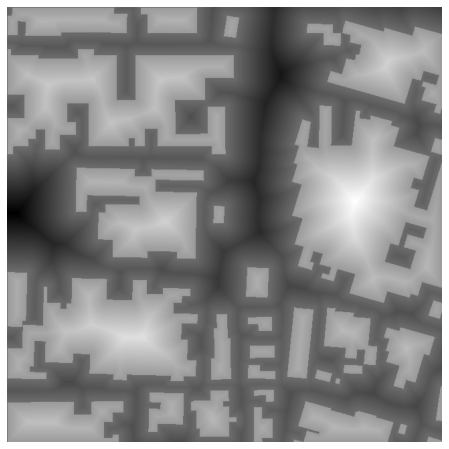

In [ ]:
plt.figure(figsize= (8, 8))
plt.axis('off')
plt.imshow(test, cmap="gray")

### Check images of unique locations

In [ ]:
#loop through folder, get filename and x,y, coordinate meta data, and see if any overlap... If they do, copy only unique locations to new a folder.  

In [ ]:
#Define file locations on desktop computer 
root = "C:/Users/sbgass/Pictures/AOI_5_Khartoum/AOI_5_Khartoum_Train/"
geojson_ext = "geojson/buildings/"                      #1012 geojson files in this directory
img_ext = "MUL-PanSharpen/"                             #1012 imgs in this directory

img_files = os.listdir(root+img_ext)
geojson_files = os.listdir(root+geojson_ext)

In [ ]:
def make_tuple(input_list):
    #turns a nexted list object into nested tuple object for hashing. 
    
    if isinstance(input_list,list):
        for i,item in enumerate(input_list):
            input_list[i] = make_tuple(item)
        input_list = tuple(input_list)
    
    return input_list

In [ ]:
from collections import defaultdict
counts = defaultdict(int)
location_dict = defaultdict(list)

for file in img_files:
    path = root+img_ext+file
    ds8 = None
    ds8 = gdal.Open(path)
    info = gdal.Info(ds8, options='-json')
    coordinates = [] 
    for key in info['cornerCoordinates'].keys():
        coordinates.append(info['cornerCoordinates'][key])
    coordinates = make_tuple(coordinates) #Should be a list of 5 coordinates for the 4 corners of the image and center. 
    counts[coordinates] += 1 
    location_dict[coordinates] += [file]


In [ ]:
#There are 1012 files in the directory, and none of them have identical corner coordinates. 
len(location_dict.keys())

1012

In [ ]:
#Check intersection in shapely 
from shapely.geometry import Polygon

intersection_count = defaultdict(int)
intersection_dict = defaultdict(list)

for img1 in location_dict.keys():
    p1 = Polygon(img1)
    for img2 in location_dict.keys():
        if img1!=img2:
            p2 = Polygon(img2)
            x = p1.intersection(p2) #this returns a shapely object of the intersection 
            if x.area/p2.area > 0.95: #95% overlapping images 
                intersection_dict[location_dict[img1][0]] += location_dict[img2] #intersection_dict records the filenames of images that intersect 
                intersection_count[location_dict[img1][0]] += 1 

In [ ]:
#No significant intersections! great! Don't have to remove any duplicates. 
len(intersection_dict.keys())

0